<h1><center>1) Текстовое</center></h1>

In [1]:
import requests
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

- [x] Скачайте текст произведения «Война и мир»: ссылка на GitHub.

In [2]:
root = 'https://raw.githubusercontent.com/netology-code/ds3-spring-2018/master/7.%20Time_series/7.4/war_and_peace/'

with open('WaP.txt', 'w', encoding='utf-8') as text_file:
    for i in range(1, 5):
        text_file.write(requests.get(f'{root}tom_{i}.txt').text)
        
with open('WaP.txt', 'r', encoding='utf-8') as text_file:
    full_text = text_file.read()
    

- [x] Очистите его, оставив только русские буквы и символы пробела.

In [3]:
clean = re.sub(r'[^а-я|\s]', '', full_text.lower())
clean = re.sub('\s+', ' ', clean).strip()

- [x] Постройте матрицу переходных вероятностей.

In [4]:
ALPHA = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(ALPHA)}

probs = np.zeros((len(ALPHA), len(ALPHA)))

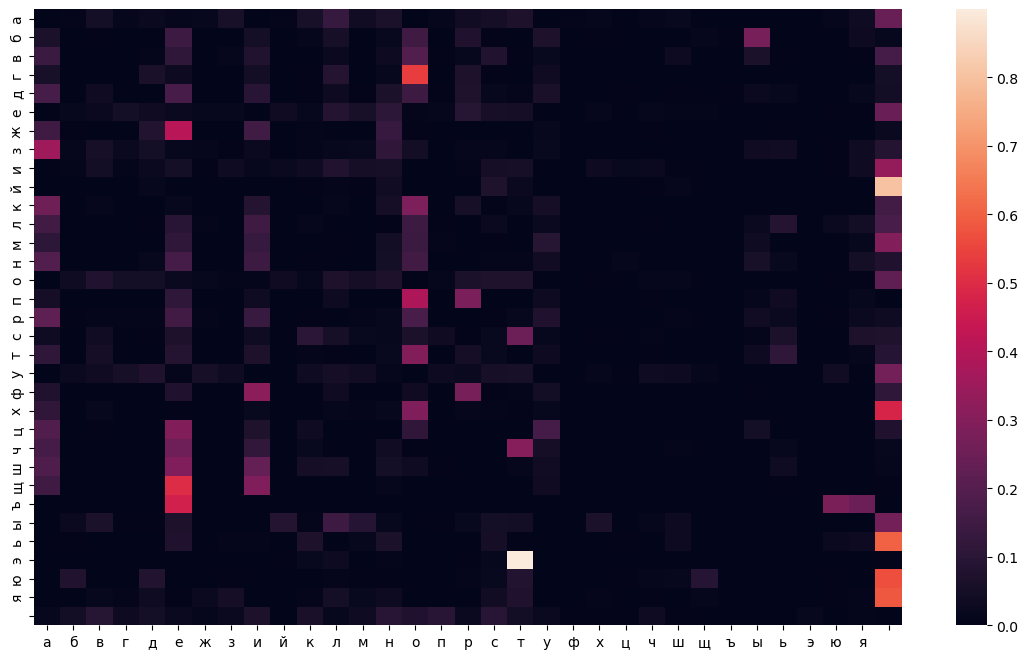

In [5]:
for cp, cn in zip(clean[:-1], clean[1:]):
    probs[POS[cp], POS[cn]] += 1

probs = (probs / probs.sum(axis=1)[:, None])
df = pd.DataFrame(probs, index=list(ALPHA), columns=list(ALPHA))

plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

- [x] Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».

In [6]:
start = POS['п']
end = POS['р']
prior = 1 / 34
res = []

for char1 in ALPHA:
    for char2 in ALPHA:
        res.append(prior * probs[start, POS[char1]] * probs[POS[char1], POS[char2]] * probs[POS[char2], end])
#         if prob > 0:
#             print(''.join(['п', char1, char2, 'р']), prob)

In [7]:
# Сложение в тервере - это логический оператор "ИЛИ", поэтому вероятность получить требуемую строку - сумма вероятностей 
# всех комбинаций
sum(res)

0.0009528383229398704

- [x] Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.

In [8]:
s = []
start = 'б'
s.append(start)

for i in range(7):
    index = POS[s[i]]
    next_char = np.random.choice(list(ALPHA), p=probs[index])
    s.append(next_char)
    
print(''.join(s))

баловегл


<h1><center>2) TS</center></h1>

- [ ] Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.

In [9]:
from hmmlearn import hmm
import warnings
warnings.filterwarnings("ignore")

In [10]:
timeseries = pd.read_csv('Gold Price.csv', index_col=0)['Price']['2021-02-24':'2022-02-24']

In [11]:
test_TS= np.array(timeseries).reshape(-1, 1)

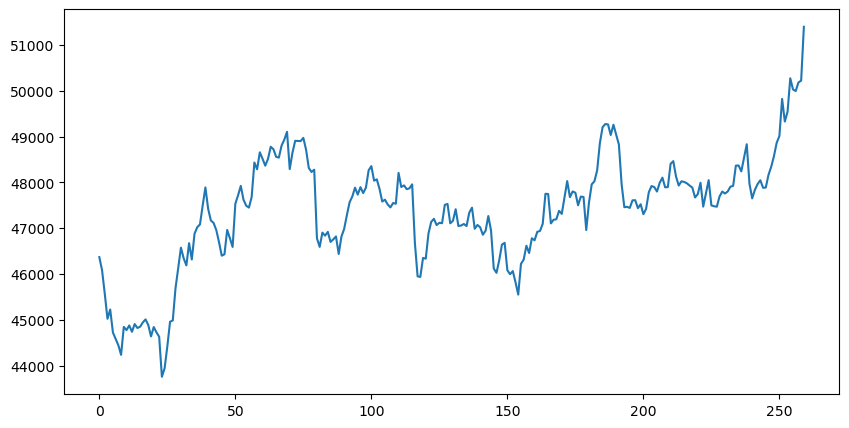

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(test_TS)

In [13]:
for i in range(1, 15):
    model = hmm.GaussianHMM(n_components=i, covariance_type='diag', n_iter=1000, random_state=15)
    model.fit(test_TS)
    print(f'states: {i} - score: {model.score(test_TS)}')

states: 1 - score: -2221.615305636979
states: 2 - score: -2129.9173237727123
states: 3 - score: -2053.8266233972336
states: 4 - score: -2137.3234176039036
states: 5 - score: -1956.743272848749
states: 6 - score: -1946.818640745328
states: 7 - score: -1927.8438936567882
states: 8 - score: -1930.650884204606
states: 9 - score: -1900.161629980487
states: 10 - score: -1896.6767914548345
states: 11 - score: -1866.9051971823105
states: 12 - score: -1921.9417558611474
states: 13 - score: -1841.8947257980858
states: 14 - score: -1882.835801963906


- [x] Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.

In [14]:
from sklearn.metrics import mean_squared_error as mse

In [15]:
# возьмём модель с наилучшим скором
model = hmm.GaussianHMM(n_components=13, covariance_type='diag', n_iter=1000, random_state=15)
model.fit(test_TS)

GaussianHMM(n_components=13, n_iter=1000, random_state=15)

In [16]:
def predict_plot(slice_=10):
    
    labels = model.predict(test_TS)
    means = np.zeros_like(test_TS)
    
    yhat = model.sample(n_samples=slice_+1, currstate=labels[-slice_], random_state=15)
    means_pred = np.zeros_like(yhat[0])

    for i in range(model.n_components):
        means[labels == i] = model.means_[i]
#         act_means[act_labels == i] = model.means_[i]
        means_pred[yhat[1] == i] = model.means_[i]


    x_slice = np.arange(len(test_TS)-slice_-1, len(test_TS))

    plt.figure(figsize=(15, 6))
    plt.plot(test_TS[:-slice_], label='test values')
    plt.plot(means[:-slice_], label='test states')
    
    plt.plot(x_slice, test_TS[-slice_-1:], label='actual values')
    plt.plot(x_slice, means[-slice_-1:], label='actual states')
    
    plt.plot(x_slice, yhat[0], label='predicted values')
    plt.plot(x_slice, means_pred, label='predicted states')

    plt.legend()
    plt.show()
    
    return test_TS[-slice_-1:], yhat[0]

- предсказываем последние 10 значений

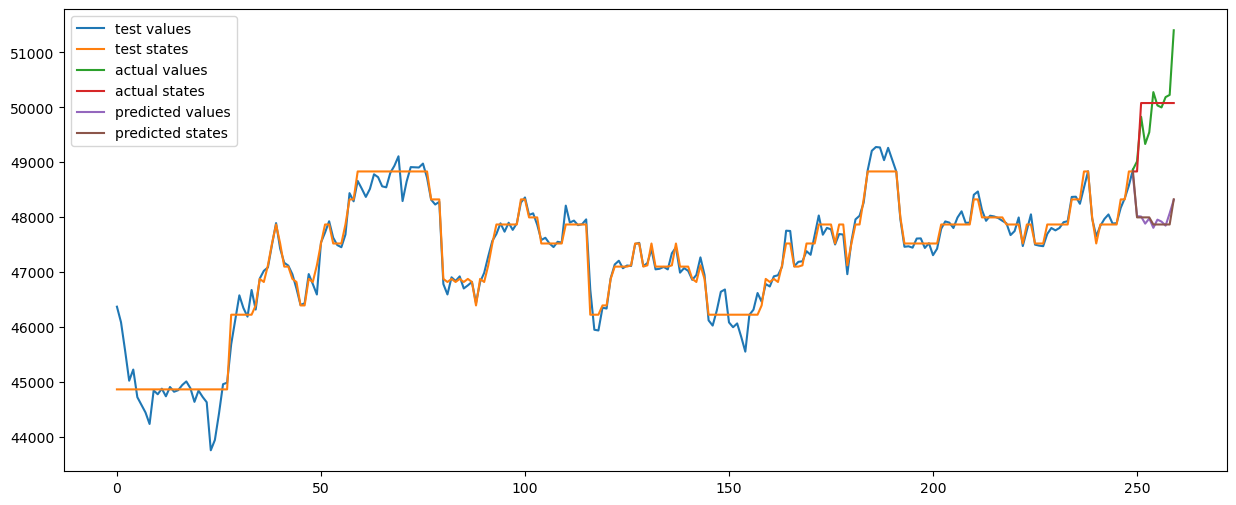

In [17]:
y_true, y_pred = predict_plot(10)

In [18]:
np.sqrt(mse(y_true, y_pred))

1983.6522304261623

- предсказываем последние 20 значений

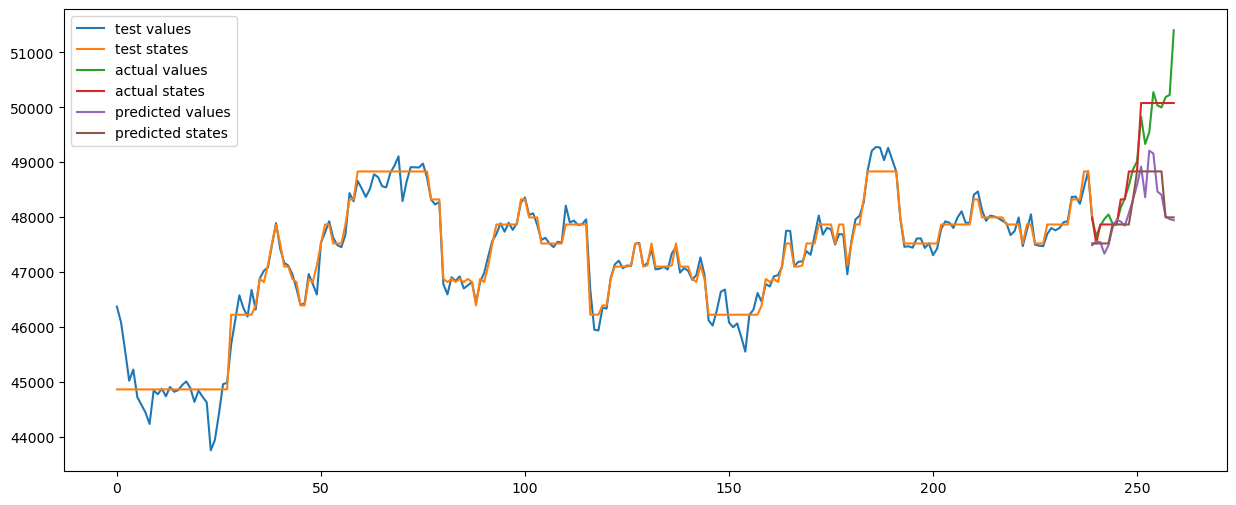

In [19]:
y_true, y_pred = predict_plot(20)

In [20]:
np.sqrt(mse(y_true, y_pred))

1235.245616535425

- предсказываем последние 30 значений

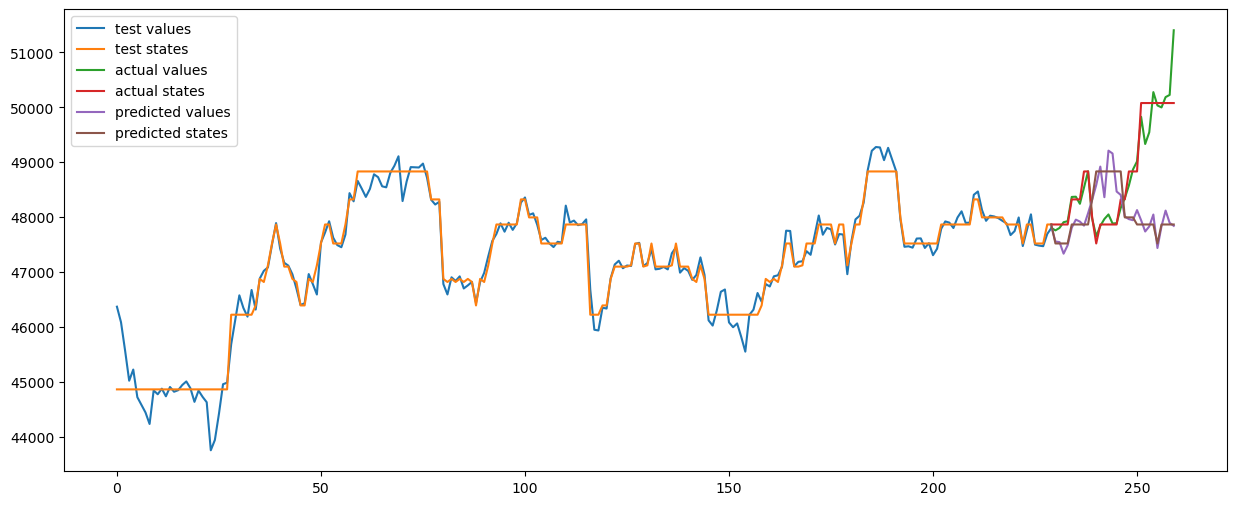

In [21]:
y_true, y_pred = predict_plot(30)

In [22]:
np.sqrt(mse(y_true, y_pred))

1366.6794716300487

- предсказываем последние 20% значений

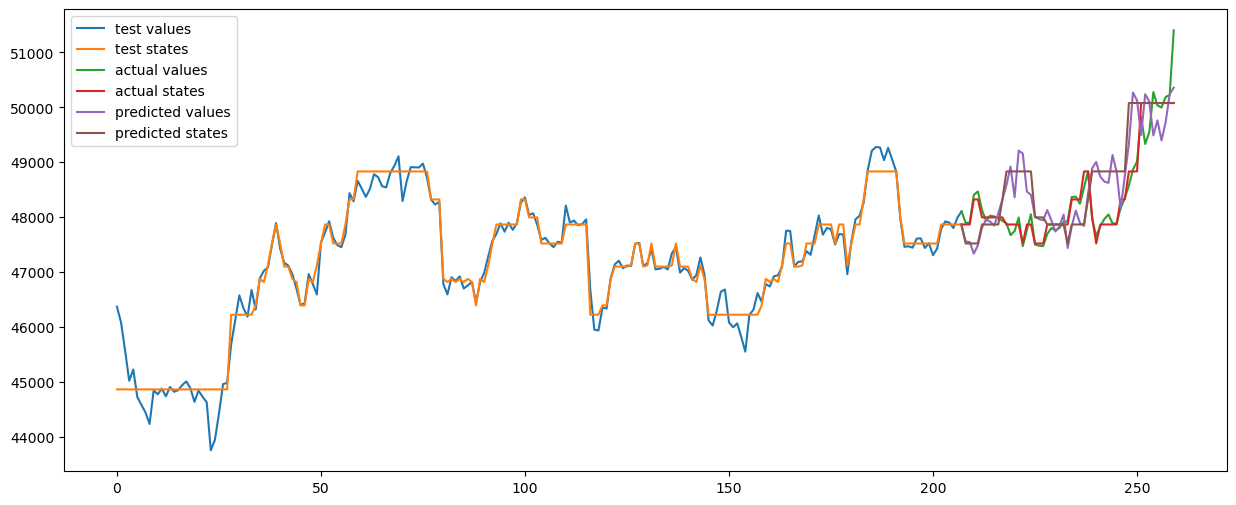

In [23]:
y_true, y_pred = predict_plot(int(len(test_TS)*.2))

In [24]:
np.sqrt(mse(y_true, y_pred))

708.6859202699887

- предсказываем последние 100 значений

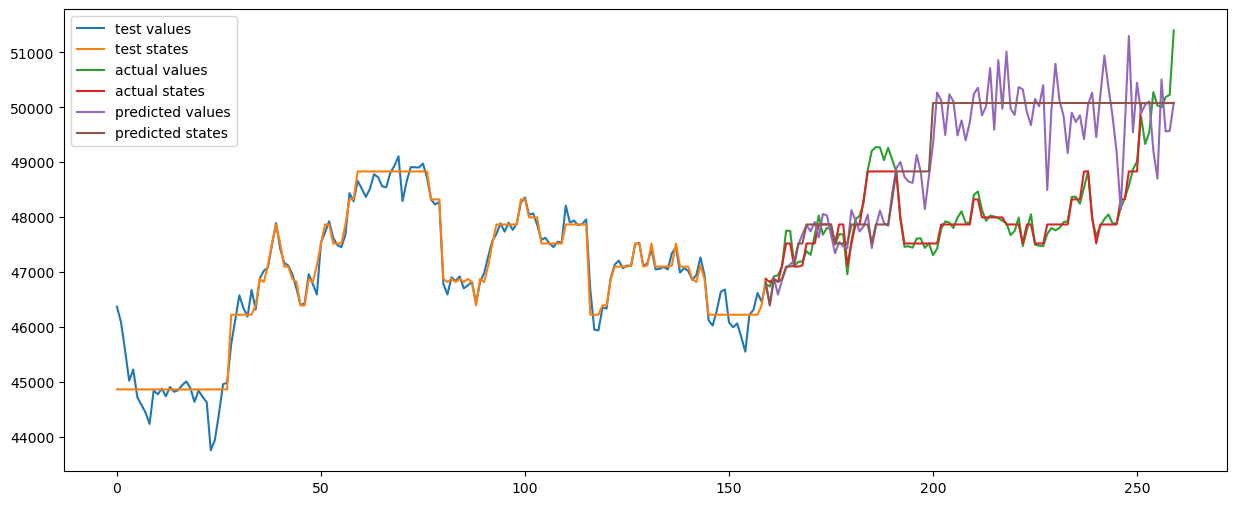

In [25]:
y_true, y_pred = predict_plot(100)

In [26]:
np.sqrt(mse(y_true, y_pred))

1579.8267553181784

# Выводы
- обучение состояний временного ряда кажется относительно реалистичным, по крайней мере, основные движения отлавливаются
- предсказание ряда и будущих состояний с помощью ф-ии sample довольно интересно себя ведёт
- наилучшую точность с точки зрения rmse показала модель, предсказывающая 20% значений
______
- нужно подробнее изучить проблему гиперпараметров марковских и скрытых марковских моделей, посмотреть на серию с учётом "умного" выставления гиперпараметров
- отдельно посмотреть на проблему распределения вероятностей и ковариации